## Setup

In this notebook we compute mean attention distances over 1000 data points from ImageNet-1k validation set. Our main source of reference is: [Do Vision Transformers See Like Convolutional Neural Networks?](https://arxiv.org/abs/2108.08810).

In [ ]:
!pip install --upgrade gdown -qq
!gdown 1oeukDq54YMV5xWFMq0j1VN25HQQAd9ei
!unzip -q 1000_val_images_sampled.zip
!wget -q https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt -O ilsvrc2012_wordnet_lemmas.txt

Downloading...
From (original): https://drive.google.com/uc?id=1oeukDq54YMV5xWFMq0j1VN25HQQAd9ei
From (redirected): https://drive.google.com/uc?id=1oeukDq54YMV5xWFMq0j1VN25HQQAd9ei&confirm=t&uuid=27ec44fd-686d-485e-a35c-2d4adfcd8e9d
To: /content/1000_val_images_sampled.zip
100% 134M/134M [00:03<00:00, 38.9MB/s]


## Imports

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras

from PIL import Image
from io import BytesIO

import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import requests
import zipfile
import gdown
import cv2
import os

## Chose the ViT model

In [ ]:
model_name = "deit_base_distilled_patch16_224"

model_handle_map = {
    "vit_base_i1k_patch16_224": "1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ",
    "vit_base_i21k_patch16_224": "1ApOdYe4NXxhPhJABefgZ3KVvqsQzhCL7",
    "dino_base_patch16_224": "16_1oDm0PeCGJ_KGBG5UKVN7TsAtiRNrN",
    "deit_base_patch16_224": "https://tfhub.dev/sayakpaul/deit_base_patch16_224/1",
    "deit_base_distilled_patch16_224": "https://tfhub.dev/sayakpaul/deit_base_distilled_patch16_224/1",
}

# Derive the patch size, image resolution, and class tokens from the model name.
splits = model_name.split("_")
model_type = splits[0]
input_resolution = int(splits[-1])
patch_size = int(splits[-2].replace("patch", ""))
num_cls_tokens = 2 if "distilled" in model_name else 1

# Get the model handle.
model_handle = model_handle_map[model_name]

print(f"Patch Size: {patch_size}.")
print(f"Input resolution: {input_resolution} x {input_resolution} x 3.")
print(f"TF-Hub handle OR Drive ID: {model_handle}.")
print(f"Number of class tokens: {num_cls_tokens}.")
print(f"Model type: {model_type}")

Patch Size: 16.
Input resolution: 224 x 224 x 3.
TF-Hub handle OR Drive ID: https://tfhub.dev/sayakpaul/deit_base_distilled_patch16_224/1.
Number of class tokens: 2.
Model type: deit


## Image preprocessing utilities

In [ ]:
crop_layer = keras.layers.CenterCrop(input_resolution, input_resolution)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, size=input_resolution):
    # turn the image into a numpy array and add batch dim
    image = tf.expand_dims(image, 0)

    # if model type is vit rescale the image to [-1, 1]
    if model_type == "vit":
        image = rescale_layer(image)

    # resize the image using bicubic interpolation
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # crop the image
    image = crop_layer(image)

    # if model type is deit normalize the image
    if model_type != "vit":
        image = norm_layer(image)

    # return the image
    return image.numpy()


def load_image_from_path(path):
    image = Image.open(path)
    image = np.array(image)
    if len(image.shape) < 3:
        image = np.tile(image[..., None], (1, 1, 3))
    preprocessed_image = preprocess_image(image)
    return image, preprocessed_image

## Prepare `tf.data.Dataset` object and load a model

In [ ]:
def get_tfhub_model(model_url: str) -> tf.keras.Model:
    inputs = tf.keras.Input((input_resolution, input_resolution, 3))
    hub_module = hub.KerasLayer(model_url)
    outputs, attention_weights = hub_module(inputs)
    return tf.keras.Model(inputs, outputs=[outputs, attention_weights])


def get_gdrive_model(model_id: str) -> tf.keras.Model:
    model_path = gdown.download(id=model_id, quiet=False)
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall()
    model_name = model_path.split(".")[0]
    inputs = tf.keras.Input((input_resolution, input_resolution, 3))
    model = tf.keras.models.load_model(model_name, compile=False)
    print(model.summary())
    outputs, attention_weights = model(inputs)
    return tf.keras.Model(inputs, outputs=[outputs, attention_weights])

In [ ]:
if len(model_handle.split("/")) > 1:
    loaded_model = get_tfhub_model(model_handle)
else:
    loaded_model = get_gdrive_model(model_handle)

In [ ]:
list_images = os.listdir("1000_val_images_sampled")
list_images = [os.path.join("1000_val_images_sampled", x) for x in list_images]

images = list()
preprocessed_images = list()
for image_path in tqdm(list_images):
    image, preprocessed_image = load_image_from_path(image_path)
    images.append(image)
    preprocessed_images.append(preprocessed_image[0])

100%|██████████| 1000/1000 [00:17<00:00, 57.36it/s]


In [ ]:
image_ds = (
    tf.data.Dataset.from_tensor_slices(preprocessed_images)
    .batch(32)
    .prefetch(tf.data.AUTOTUNE)
)

## Mean Attention Distance

Reference: https://gist.github.com/simonster/155894d48aef2bd36bd2dd8267e62391

### Compute Mean Distance
![Compute Mean Distance](https://i.imgur.com/nyuS9H9.png)

In [ ]:
def compute_distance_matrix(patch_size, num_patches, length):
    """Helper function to compute distance matrix."""
    distance_matrix = np.zeros((num_patches, num_patches))
    for i in range(num_patches):
        for j in range(num_patches):
            if i == j:  # zero distance
                continue

            xi, yi = (int(i / length)), (i % length)
            xj, yj = (int(j / length)), (j % length)
            distance_matrix[i, j] = patch_size * np.linalg.norm([xi - xj, yi - yj])

    return distance_matrix


def compute_mean_attention_dist(patch_size, attention_weights):
    # The attention_weights shape = (batch, num_heads, num_patches, num_patches)
    attention_weights = attention_weights[
        ..., num_cls_tokens:, num_cls_tokens:
    ]  # Removing the CLS token
    num_patches = attention_weights.shape[-1]
    length = int(np.sqrt(num_patches))
    assert length ** 2 == num_patches, "Num patches is not perfect square"

    distance_matrix = compute_distance_matrix(patch_size, num_patches, length)
    h, w = distance_matrix.shape

    distance_matrix = distance_matrix.reshape((1, 1, h, w))
    # The attention_weights along the last axis adds to 1
    # this is due to the fact that they are softmax of the raw logits
    # summation of the (attention_weights * distance_matrix)
    # should result in an average distance per token
    mean_distances = attention_weights * distance_matrix
    mean_distances = np.sum(
        mean_distances, axis=-1
    )  # sum along last axis to get average distance per token
    mean_distances = np.mean(
        mean_distances, axis=-1
    )  # now average across all the tokens

    return mean_distances

In [ ]:
mean_distances = dict()
for idx, image in tqdm(enumerate(image_ds)):
    _, attention_score_dict = loaded_model.predict(image)
    # Calculate the mean distances for every transformer block.
    for name, attention_weight in attention_score_dict.items():
        mean_distance = compute_mean_attention_dist(
            patch_size=patch_size,
            attention_weights=attention_weight,
        )
        if idx == 0:
            mean_distances[f"{name}_mean_dist"] = mean_distance
        else:
            mean_distances[f"{name}_mean_dist"] = tf.concat(
                [mean_distance, mean_distances[f"{name}_mean_dist"]], axis=0
            )

0it [00:00, ?it/s]

1/1 [==============================] - 2s 2s/step


1it [00:09,  9.60s/it]

1/1 [==============================] - 0s 40ms/step


2it [00:15,  7.16s/it]

1/1 [==============================] - 0s 44ms/step


3it [00:20,  6.30s/it]

1/1 [==============================] - 0s 30ms/step


4it [00:24,  5.45s/it]

1/1 [==============================] - 0s 32ms/step


5it [00:29,  5.16s/it]

1/1 [==============================] - 0s 49ms/step


6it [00:34,  5.21s/it]

1/1 [==============================] - 0s 41ms/step


7it [00:38,  4.80s/it]

1/1 [==============================] - 0s 39ms/step


8it [00:43,  4.87s/it]

1/1 [==============================] - 0s 49ms/step


9it [00:47,  4.62s/it]

1/1 [==============================] - 0s 32ms/step


10it [00:51,  4.41s/it]

1/1 [==============================] - 0s 39ms/step


11it [00:56,  4.68s/it]

1/1 [==============================] - 0s 30ms/step


12it [01:00,  4.49s/it]

1/1 [==============================] - 0s 30ms/step


13it [01:04,  4.34s/it]

1/1 [==============================] - 0s 33ms/step


14it [01:10,  4.62s/it]

1/1 [==============================] - 0s 31ms/step


15it [01:14,  4.43s/it]

1/1 [==============================] - 0s 30ms/step


16it [01:17,  4.28s/it]

1/1 [==============================] - 0s 31ms/step


17it [01:23,  4.56s/it]

1/1 [==============================] - 0s 32ms/step


18it [01:27,  4.39s/it]

1/1 [==============================] - 0s 39ms/step


19it [01:31,  4.28s/it]

1/1 [==============================] - 0s 30ms/step


20it [01:36,  4.55s/it]

1/1 [==============================] - 0s 32ms/step


21it [01:40,  4.40s/it]

1/1 [==============================] - 0s 30ms/step


22it [01:44,  4.28s/it]

1/1 [==============================] - 0s 31ms/step


23it [01:49,  4.54s/it]

1/1 [==============================] - 0s 31ms/step


24it [01:53,  4.38s/it]

1/1 [==============================] - 0s 31ms/step


25it [01:57,  4.26s/it]

1/1 [==============================] - 0s 30ms/step


26it [02:02,  4.48s/it]

1/1 [==============================] - 0s 31ms/step


27it [02:06,  4.36s/it]

1/1 [==============================] - 0s 30ms/step


28it [02:10,  4.26s/it]

1/1 [==============================] - 0s 31ms/step


29it [02:15,  4.51s/it]

1/1 [==============================] - 0s 32ms/step


30it [02:19,  4.34s/it]

1/1 [==============================] - 0s 31ms/step


31it [02:23,  4.21s/it]

1/1 [==============================] - 1s 1s/step


32it [02:28,  4.64s/it]


In [ ]:
# For a single transforer block, we have attention distances
# for 1000 images for each attention head. We have 12 such
# attention head per transformer block.
mean_distances["transformer_block_0_att_mean_dist"].shape

TensorShape([1000, 12])

In [ ]:
# Get the number of heads from the mean distance output
num_heads = tf.shape(mean_distances["transformer_block_0_att_mean_dist"])[-1].numpy()

# Print the shapes
print(f"Num Heads: {num_heads}")

Num Heads: 12


In [ ]:
for key, value in mean_distances.items():
    mean_distances[key] = tf.reduce_mean(value, axis=0, keepdims=True)

In [ ]:
# For a single transformer block we have calculate mean attention distances
# for 12 attention heads.
mean_distances["transformer_block_0_att_mean_dist"].shape

TensorShape([1, 12])

## Visualize the mean distances

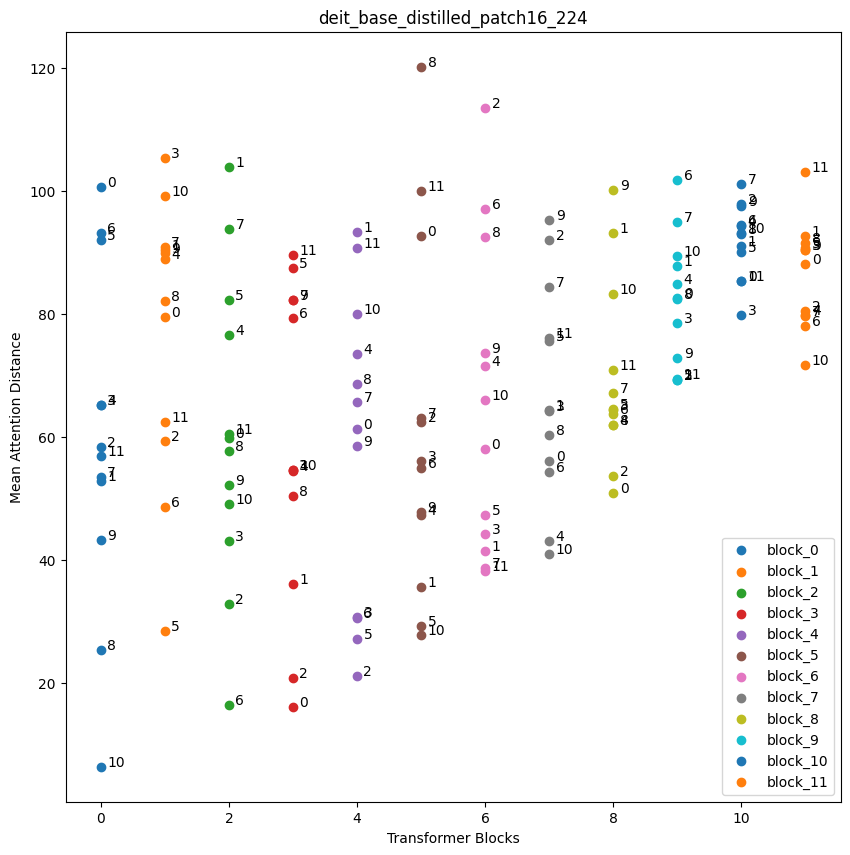

In [ ]:
plt.figure(figsize=(10, 10))

first = list()
last = list()

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]

    x = [idx] * num_heads
    y = mean_distance[0, :]

    plt.scatter(x=x, y=y, label=f"block_{idx}")
    for i, txt in enumerate(range(num_heads)):
        plt.annotate(txt, (x[i] + 0.1, y[i] + 0.1))

plt.xlabel("Transformer Blocks")
plt.ylabel("Mean Attention Distance")
plt.legend(loc="lower right")
plt.title(model_name)
plt.show()

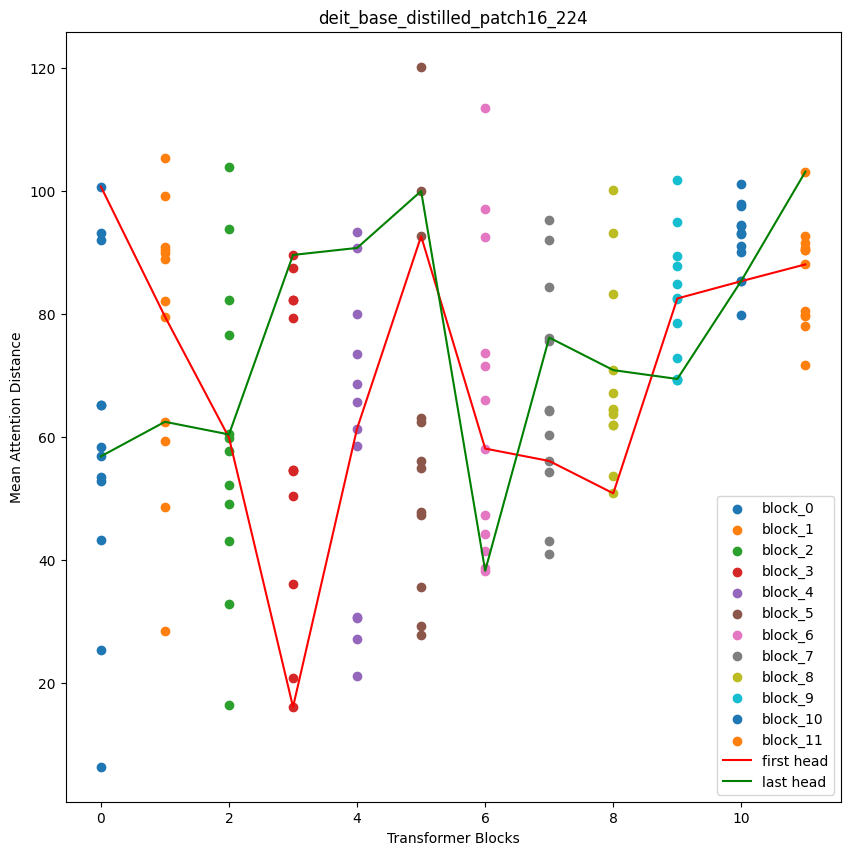

In [ ]:
plt.figure(figsize=(10, 10))

first = list()
last = list()

for idx in range(len(mean_distances)):
    mean_distance = mean_distances[f"transformer_block_{idx}_att_mean_dist"]

    x = [idx] * num_heads
    y = mean_distance[0, :]

    plt.scatter(x=x, y=y, label=f"block_{idx}")

    first.append(y[0])
    last.append(y[-1])

plt.plot(first, "r-", label="first head")
plt.plot(last, "g-", label="last head")

plt.xlabel("Transformer Blocks")
plt.ylabel("Mean Attention Distance")
plt.legend(loc="lower right")
plt.title(model_name)
plt.show()

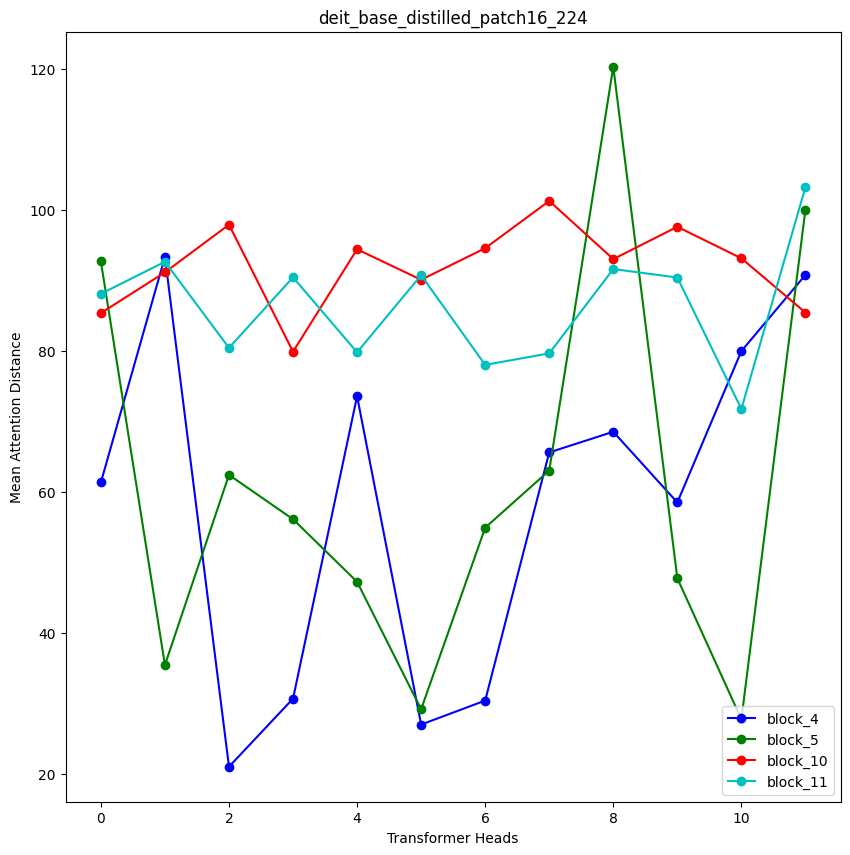

In [ ]:
plt.figure(figsize=(10, 10))

first = list()
last = list()

blocks = [4, 5, 10, 11]
chars = ["-o", "-o", "-o", "-o"]
colors = ["b", "g", "r", "c"]

for idx, block_num in enumerate(blocks):
    mean_distance = mean_distances[f"transformer_block_{block_num}_att_mean_dist"]

    x = list(range(num_heads))
    y = mean_distance[0, :]

    plt.plot(x, y, f"{colors[idx]}{chars[idx]}", label=f"block_{block_num}")

plt.xlabel("Transformer Heads")
plt.ylabel("Mean Attention Distance")
plt.legend(loc="lower right")
plt.title(model_name)

# Save the plot to a file
plt.savefig("plot.png", format="png")

plt.show()